In [1]:
import os
import math
import random
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
from scipy.linalg import sqrtm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3, Inception_V3_Weights


# ==========================
# Config
# ==========================

@dataclass
class CFG:
    image_size: int = 32
    channels: int = 3
    num_classes: int = 10  # not using class-conditioning here
    timesteps: int = 1000
    beta_start: float = 1e-4
    beta_end: float = 0.02

    batch_size: int = 128
    num_epochs: int = 200   # you can temporarily lower to 20–50 for testing
    lr: float = 2e-4
    num_workers: int = 4

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    out_dir: str = "./ddpm_cifar10_hw5"

    fid_num_gen: int = 5000  # how many generated samples to use for FID
    fid_batch_size: int = 100

    sample_grid_10: bool = True
    sample_grid_64: bool = True

    use_amp: bool = True  # mixed precision


CFG = CFG()


# ==========================
# Utils: seeding, dirs
# ==========================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def ensure_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)


In [2]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: [B] with integer timesteps
        returns: [B, dim]
        """
        device = t.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int, num_groups: int = 8):
        super().__init__()

        # pick a valid num_groups for in_channels
        g1 = min(num_groups, in_channels)
        while g1 > 1 and (in_channels % g1 != 0):
            g1 -= 1

        # pick a valid num_groups for out_channels
        g2 = min(num_groups, out_channels)
        while g2 > 1 and (out_channels % g2 != 0):
            g2 -= 1

        self.norm1 = nn.GroupNorm(g1, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(g2, out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        time_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.shortcut(x)


class Downsample(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet(nn.Module):
    """
    32x32 -> 16x16 -> 8x8 -> 16x16 -> 32x32 with clean skips:
      x1: 32x32, 64ch
      x2: 16x16, 128ch
      x3/bottleneck: 8x8, 256ch
    """
    def __init__(self, img_channels: int = 3, base_channels: int = 64, time_emb_dim: int = 256):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Encoder
        self.inc = ResidualBlock(img_channels, base_channels, time_emb_dim)  # 3 -> 64 @ 32x32

        self.down1_pool = Downsample(base_channels)                          # 64 @ 32x32 -> 64 @ 16x16
        self.down1_block = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)  # 64 -> 128 @ 16x16

        self.down2_pool = Downsample(base_channels * 2)                      # 128 @ 16x16 -> 128 @ 8x8
        self.down2_block = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)  # 128 -> 256 @ 8x8

        # Bottleneck
        self.bot1 = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)  # 256 -> 256 @ 8x8
        self.bot2 = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)  # 256 -> 256 @ 8x8

        # Decoder
        self.up1 = Upsample(base_channels * 4)  # 256 @ 8x8 -> 256 @ 16x16
        self.dec1 = ResidualBlock(base_channels * 4 + base_channels * 2,  # 256 + 128 = 384
                                  base_channels * 2, time_emb_dim)        # -> 128 @ 16x16

        self.up2 = Upsample(base_channels * 2)  # 128 @ 16x16 -> 128 @ 32x32
        self.dec2 = ResidualBlock(base_channels * 2 + base_channels,      # 128 + 64 = 192
                                  base_channels, time_emb_dim)            # -> 64 @ 32x32

        self.outc = nn.Sequential(
            nn.GroupNorm(8, base_channels),   # 64 is divisible by 8
            nn.SiLU(),
            nn.Conv2d(base_channels, img_channels, kernel_size=3, padding=1)
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # t: [B], integer timesteps
        t_emb = self.time_mlp(t)

        # Encoder
        x1 = self.inc(x, t_emb)              # [B, 64, 32, 32]

        p1 = self.down1_pool(x1)             # [B, 64, 16, 16]
        x2 = self.down1_block(p1, t_emb)     # [B, 128,16, 16]

        p2 = self.down2_pool(x2)             # [B, 128, 8, 8]
        x3 = self.down2_block(p2, t_emb)     # [B, 256, 8, 8]

        # Bottleneck
        b = self.bot1(x3, t_emb)             # [B, 256, 8, 8]
        b = self.bot2(b, t_emb)              # [B, 256, 8, 8]

        # Decoder
        u1 = self.up1(b)                     # [B, 256, 16, 16]
        u1 = torch.cat([u1, x2], dim=1)      # [B, 256+128=384, 16, 16]
        u1 = self.dec1(u1, t_emb)            # [B, 128, 16, 16]

        u2 = self.up2(u1)                    # [B, 128, 32, 32]
        u2 = torch.cat([u2, x1], dim=1)      # [B, 128+64=192, 32, 32]
        u2 = self.dec2(u2, t_emb)            # [B, 64, 32, 32]

        out = self.outc(u2)                  # [B, 3, 32, 32]
        return out


class DDPM(nn.Module):
    def __init__(self, model: nn.Module, timesteps: int = 1000,
                 beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()
        self.model = model
        self.timesteps = timesteps

        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod",
                             torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))

        # previous alpha_cumprod: [1, a1, a1*a2, ...]
        alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=alphas_cumprod.device), alphas_cumprod[:-1]], dim=0
        )
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)

        # Equation for posterior variance
        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.register_buffer("posterior_variance", posterior_variance)

    def q_sample(self, x_start: torch.Tensor, t: torch.Tensor,
                 noise: torch.Tensor = None) -> torch.Tensor:
        """
        Diffuse the data (forward process): q(x_t | x_0)
        x_start: [B,3,32,32] in [-1,1]
        t: [B] integer timesteps
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    @torch.no_grad()
    def p_sample(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Sample x_{t-1} from x_t
        """
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].view(-1, 1, 1, 1)

        # Predict noise
        eps_theta = self.model(x, t)

        # Equation 11 in DDPM paper
        model_mean = sqrt_recip_alphas_t * (x - betas_t * eps_theta / sqrt_one_minus_alphas_cumprod_t)

        if t[0] == 0:
            return model_mean

        posterior_var_t = self.posterior_variance[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_var_t) * noise

    @torch.no_grad()
    def sample(self, num_samples: int, device: str = "cuda") -> torch.Tensor:
        self.model.eval()
        x = torch.randn(num_samples, 3, CFG.image_size, CFG.image_size, device=device)

        for step in reversed(range(self.timesteps)):
            t_batch = torch.full((num_samples,), step, device=device, dtype=torch.long)
            x = self.p_sample(x, t_batch)

        self.model.train()
        return x


In [3]:
def get_cifar10_dataloaders() -> Tuple[DataLoader, DataLoader]:
    transform = transforms.Compose([
        transforms.ToTensor(),  # [0,1]
        transforms.Lambda(lambda x: x * 2.0 - 1.0)  # scale to [-1,1]
    ])

    train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(
        train_set,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_set,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True
    )
    return train_loader, test_loader


In [4]:
@torch.no_grad()
def get_inception_model(device: str):
    # Use default weights and let torchvision handle aux_logits internally
    weights = Inception_V3_Weights.DEFAULT
    model = inception_v3(weights=weights)   # <- no aux_logits=False here
    model.fc = nn.Identity()                # return 2048-d features instead of logits
    model.to(device)
    model.eval()
    return model


def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Standard FID formula between two Gaussians.
    """
    diff = mu1 - mu2

    covmean = sqrtm(sigma1.dot(sigma2))
    if not np.isfinite(covmean).all():
        print("[FID] Adding eps to diagonal of covariances for numerical stability")
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2.0 * tr_covmean
    return float(fid)


@torch.no_grad()
def get_activations_from_generator(model_ddpm, device: str,
                                   num_samples: int, batch_size: int) -> np.ndarray:
    """
    Generate samples with DDPM and compute Inception activations.
    """
    inc = get_inception_model(device)
    all_acts = []

    remaining = num_samples
    while remaining > 0:
        cur_bs = min(batch_size, remaining)
        samples = model_ddpm.sample(num_samples=cur_bs, device=device)
        samples = (samples.clamp(-1, 1) + 1.0) / 2.0
        samples = F.interpolate(samples, size=(299, 299),
                                mode="bilinear", align_corners=False)

        feat = inc(samples)  # [B, 2048] after fc=Identity
        # In case some torchvision version returns a namedtuple, handle that:
        if hasattr(feat, "logits"):
            feat = feat.logits
        all_acts.append(feat.cpu().numpy())

        remaining -= cur_bs

    acts = np.concatenate(all_acts, axis=0)
    return acts[:num_samples]


@torch.no_grad()
def compute_fid_for_ddpm(model_ddpm, real_loader):
    """
    1) Compute Inception activations for real CIFAR-10 images
    2) Compute Inception activations for generated images
    3) Return FID
    """
    device = CFG.device
    inc = get_inception_model(device)

    print("Computing real activations for FID ...")
    real_acts = []
    num_seen = 0
    max_real = CFG.fid_num_gen  # match roughly the number of generated samples

    with torch.no_grad():
        for x, _ in real_loader:
            x = x.to(device)
            x = (x + 1.0) / 2.0
            x = F.interpolate(x, size=(299, 299),
                              mode="bilinear", align_corners=False)
            feat = inc(x)
            if hasattr(feat, "logits"):
                feat = feat.logits
            real_acts.append(feat.cpu().numpy())
            num_seen += x.size(0)
            if num_seen >= max_real:
                break

    real_acts = np.concatenate(real_acts, axis=0)
    real_acts = real_acts[:max_real]
    mu_real = np.mean(real_acts, axis=0)
    sigma_real = np.cov(real_acts, rowvar=False)

    print("Computing generated activations for FID ...")
    gen_acts = get_activations_from_generator(
        model_ddpm, device=device,
        num_samples=CFG.fid_num_gen,
        batch_size=CFG.fid_batch_size
    )
    mu_gen = np.mean(gen_acts, axis=0)
    sigma_gen = np.cov(gen_acts, rowvar=False)

    fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
    return fid


# ==========================
# Loss plotting
# ==========================

def plot_losses(losses: List[float], out_path: str):
    plt.figure()
    plt.plot(range(1, len(losses) + 1), losses, marker="o", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss (MSE)")
    plt.title("DDPM Training Loss on CIFAR-10")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


In [5]:
def train_ddpm():
    set_seed(42)
    ensure_dir(CFG.out_dir)

    train_loader, test_loader = get_cifar10_dataloaders()

    model = UNet(img_channels=CFG.channels, base_channels=64, time_emb_dim=256).to(CFG.device)
    ddpm = DDPM(model, timesteps=CFG.timesteps,
                beta_start=CFG.beta_start, beta_end=CFG.beta_end).to(CFG.device)

    optimizer = torch.optim.Adam(ddpm.parameters(), lr=CFG.lr)

    scaler = None
    if CFG.use_amp and CFG.device.startswith("cuda"):
        # If this line errors on your PyTorch version, replace with:
        #   from torch.cuda.amp import GradScaler, autocast
        #   scaler = GradScaler()
        scaler = torch.amp.GradScaler("cuda")

    global_step = 0
    epoch_losses: List[float] = []

    for epoch in range(1, CFG.num_epochs + 1):
        ddpm.train()
        running_loss = 0.0
        num_batches = 0

        for x, _ in train_loader:
            x = x.to(CFG.device)  # [-1,1]
            b = x.size(0)

            t = torch.randint(0, CFG.timesteps, (b,), device=CFG.device).long()
            noise = torch.randn_like(x)
            x_t = ddpm.q_sample(x, t, noise)

            optimizer.zero_grad(set_to_none=True)

            if scaler is not None:
                with torch.amp.autocast("cuda"):
                    noise_pred = ddpm.model(x_t, t)
                    loss = F.mse_loss(noise_pred, noise)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                noise_pred = ddpm.model(x_t, t)
                loss = F.mse_loss(noise_pred, noise)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            num_batches += 1
            global_step += 1

        avg_loss = running_loss / max(1, num_batches)
        epoch_losses.append(avg_loss)
        print(f"[Epoch {epoch}/{CFG.num_epochs}] loss = {avg_loss:.4f}")

        # Save a small sample grid every few epochs (optional)
        if epoch % 20 == 0 or epoch == CFG.num_epochs:
            with torch.no_grad():
                samples = ddpm.sample(num_samples=64, device=CFG.device)
                samples = (samples.clamp(-1, 1) + 1.0) / 2.0
                grid = vutils.make_grid(samples, nrow=8)
                vutils.save_image(grid, os.path.join(CFG.out_dir, f"samples_epoch_{epoch}.png"))

    # Save model & losses
    torch.save(ddpm.state_dict(), os.path.join(CFG.out_dir, "ddpm_cifar10.pt"))
    np.save(os.path.join(CFG.out_dir, "train_losses.npy"), np.array(epoch_losses))
    plot_losses(epoch_losses, os.path.join(CFG.out_dir, "loss_curve.png"))

    # Final sample grids for the report
    with torch.no_grad():
        if CFG.sample_grid_10:
            samples_10 = ddpm.sample(num_samples=10, device=CFG.device)
            samples_10 = (samples_10.clamp(-1, 1) + 1.0) / 2.0
            grid_10 = vutils.make_grid(samples_10, nrow=5)
            vutils.save_image(grid_10, os.path.join(CFG.out_dir, "samples_10.png"))

        if CFG.sample_grid_64:
            samples_64 = ddpm.sample(num_samples=64, device=CFG.device)
            samples_64 = (samples_64.clamp(-1, 1) + 1.0) / 2.0
            grid_64 = vutils.make_grid(samples_64, nrow=8)
            vutils.save_image(grid_64, os.path.join(CFG.out_dir, "samples_64.png"))

    # Compute FID using test set as "real"
    fid_value = compute_fid_for_ddpm(ddpm, test_loader)
    print(f"\n=== FID on CIFAR-10 test set (using {CFG.fid_num_gen} generated samples) = {fid_value:.4f} ===")

    return ddpm, epoch_losses, fid_value


# ==========================
# Run training
# ==========================

print("=== Training DDPM on CIFAR-10 for HW5 ===")
print(f"Device: {CFG.device}, epochs: {CFG.num_epochs}, timesteps: {CFG.timesteps}")

ddpm_model, losses, fid_value = train_ddpm()

print("Training done.")
print(f"Final FID: {fid_value:.4f}")
print(f"Outputs saved under: {CFG.out_dir}")


=== Training DDPM on CIFAR-10 for HW5 ===
Device: cuda, epochs: 200, timesteps: 1000
[Epoch 1/200] loss = 0.0988
[Epoch 2/200] loss = 0.0493
[Epoch 3/200] loss = 0.0438
[Epoch 4/200] loss = 0.0402
[Epoch 5/200] loss = 0.0395
[Epoch 6/200] loss = 0.0379
[Epoch 7/200] loss = 0.0374
[Epoch 8/200] loss = 0.0365
[Epoch 9/200] loss = 0.0364
[Epoch 10/200] loss = 0.0356
[Epoch 11/200] loss = 0.0359
[Epoch 12/200] loss = 0.0348
[Epoch 13/200] loss = 0.0350
[Epoch 14/200] loss = 0.0349
[Epoch 15/200] loss = 0.0344
[Epoch 16/200] loss = 0.0338
[Epoch 17/200] loss = 0.0338
[Epoch 18/200] loss = 0.0343
[Epoch 19/200] loss = 0.0335
[Epoch 20/200] loss = 0.0338
[Epoch 21/200] loss = 0.0340
[Epoch 22/200] loss = 0.0331
[Epoch 23/200] loss = 0.0341
[Epoch 24/200] loss = 0.0335
[Epoch 25/200] loss = 0.0335
[Epoch 26/200] loss = 0.0332
[Epoch 27/200] loss = 0.0334
[Epoch 28/200] loss = 0.0332
[Epoch 29/200] loss = 0.0329
[Epoch 30/200] loss = 0.0323
[Epoch 31/200] loss = 0.0325
[Epoch 32/200] loss = 0.0

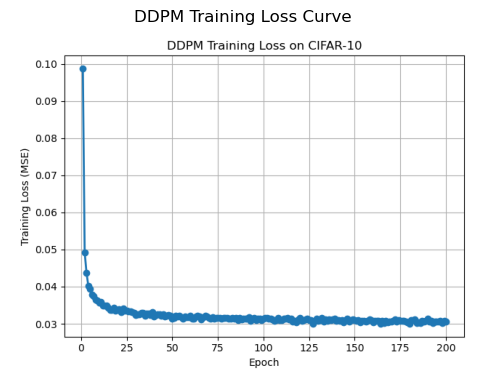

In [6]:
loss_curve_path = os.path.join(CFG.out_dir, "loss_curve.png")
img = plt.imread(loss_curve_path)

plt.figure(figsize=(6, 5))
plt.imshow(img)
plt.title("DDPM Training Loss Curve")
plt.axis("off")
plt.show()


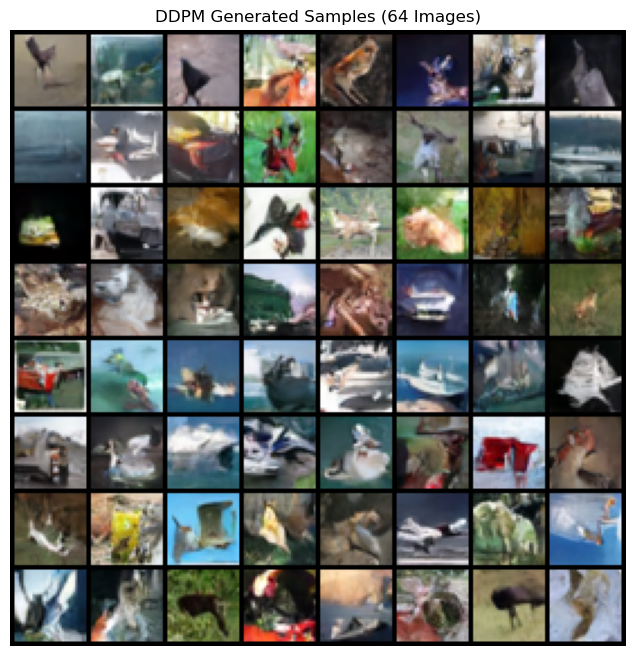

In [7]:
img_path = os.path.join(CFG.out_dir, "samples_64.png")
img = plt.imread(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("DDPM Generated Samples (64 Images)")
plt.axis("off")
plt.show()
